# Segmentation Notebook
---
Notebook to experiment / compare various segmentation algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import source as source

In [2]:
# Optional code to load in your ViT model for embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
embedding_model = source.load_ViT(device=device)

# If you want to ignore, just set embedding_model to None
# embedding_model = None

Device: cpu


C:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\image_encoder\transformers\vision_transformer.py:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chec

Vision Transformer instantiated with 125,024 parameters using Sinusoidal encodings.
Model loaded from image_encoder/trained_models/vit_11-18_sinusoid125k.pth on cpu


In [3]:
train_dataset = source.load_dataset(mode='training')
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = source.load_dataset(mode='evaluation')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


my_objs = dict()
last_id = None

Problem b6afb2da:

Input Image:


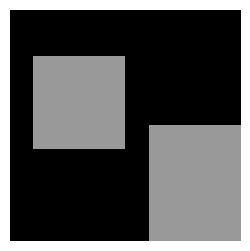


Output Image:


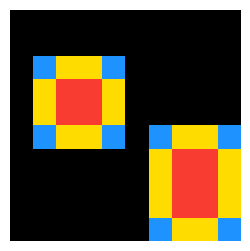

Inputs further segmented into 2 objects.
Outputs further segmented into 2 objects.


In [4]:
# Main loop processing data
for i, data in enumerate(train_dataloader):
    id = data['id'][0]
    last_id = id
    train = data['train']
    test = data['test']
    
    for t in train:
        # Will work within numpy for simplicity
        input_image = t['input'].squeeze(0).numpy()
        output_image = t['output'].squeeze(0).numpy()

        # Convert to ARC_Objects and add to our dict
        input_object = source.ARC_Object(image=input_image, mask=np.ones_like(input_image), parent=None, embedding_model=embedding_model)
        output_object = source.ARC_Object(image=output_image, mask=np.ones_like(output_image), parent=None, embedding_model=embedding_model)
        my_objs[id] = {'input': [input_object], 'output': [output_object]}

        # Print out problem (input and output)
        print(f"Problem {id}:\n{'='*100}")
        print("\nInput Image:")
        source.plot_image_and_mask(input_image)
        print("\nOutput Image:")
        source.plot_image_and_mask(output_image)
        
        # Extract objects using segmentation
        input_extraction = source.extract_objects(input_object, method='contour_scale', embedding_model=embedding_model)
        output_extraction  = source.extract_objects(output_object, method='contour_scale', embedding_model=embedding_model)
        print(f"Inputs further segmented into {len(input_extraction)} objects.\nOutputs further segmented into {len(output_extraction)} objects.")
        # Add to our dict
        my_objs[id]['input'].extend(input_extraction)
        my_objs[id]['output'].extend(output_extraction)
        break
    break

In [5]:
def plot_segmented_objects(problem_id):
    input_objs = my_objs[problem_id]['input']
    output_objs = my_objs[problem_id]['output']
    print_segmented_objects = False

    for obj in input_objs:
        print(f"Input Source Object:\n{'='*100}")
        obj.plot_grid()
        print(f"Segmented Objects:\n{'='*100}")
        new_objs = source.extract_objects(obj, method='color', print_on_init=print_segmented_objects)
        print(f"Further segmented into {len(new_objs)} objects\n\n")

    print(f"\n\n")
    for obj in output_objs:
        print(f"Output Source Object:\n{'='*100}")
        obj.plot_grid()
        print(f"Segmented Objects:\n{'='*100}")
        new_objs = source.extract_objects(obj, method='color', print_on_init=print_segmented_objects)
        print(f"Further segmented into {len(new_objs)} objects\n\n")

# problem_id = "178fcbfb"
problem_id = last_id
# plot_segmented_objects(problem_id)

In [6]:
obj_pointers = []
obj_tensors = []

for id in my_objs:
    for obj in my_objs[id]['input']:
        obj_pointers.append(obj)
        obj_tensors.append(obj.embedding)
    for obj in my_objs[id]['output']:
        obj_pointers.append(obj)
        obj_tensors.append(obj.embedding)

In [7]:
def get_cosine_similarity(vector, tensors, k=5):
    tensor = torch.stack(tensors, dim=0)
    similarity = torch.nn.functional.cosine_similarity(vector.unsqueeze(0), tensor, dim=1)
    topk_similarity, topk_indices = torch.topk(similarity, k=k, dim=0)
    return topk_similarity, topk_indices

Target Object @ ID: 1


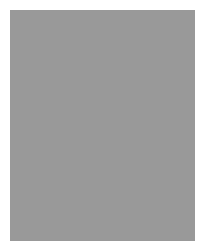




tensor(0.9968)


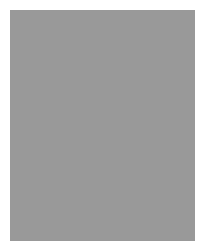

tensor(0.9851)


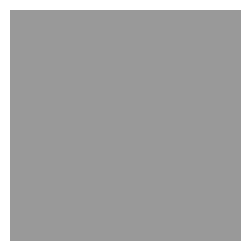

tensor(0.9736)


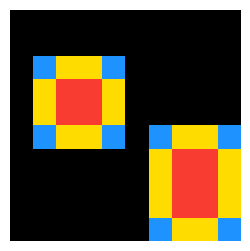

tensor(0.8116)


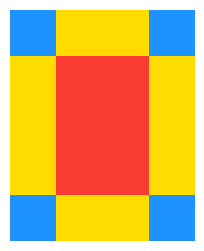

In [8]:
target_id = 1
print(f"Target Object @ ID: {target_id}")
obj_pointers[target_id].plot_grid()
print(f"\n\n")

sim, indices = get_cosine_similarity(obj_tensors[target_id], obj_tensors, k=5)
for i, index in enumerate(indices):
    if index == target_id:
        continue
    print(sim[i])
    obj_pointers[i].plot_grid()